# Webscraping of Understat using the Beautiful Soup



**By Jose Gonzalez**


**Was inspired a lot by the [McKay Johns tutorial](https://www.youtube.com/watch?v=IsR5FrjNmro) he has great tutorials on shotmaps, passing networks, dashboards etc , [here is Youtube channel](https://www.youtube.com/c/mckayjohns)**

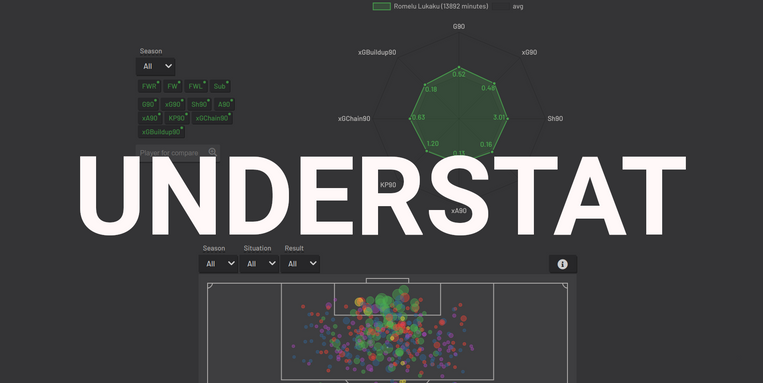

<a id="1."></a>
# 1. Introduction

This is the beggining of my Understat series in which I intent to using 3 different methods to scrape data from [Understat](https://understat.com/) using Selenium, The Understat module created by [Amos Sebastian](https://understat.readthedocs.io/en/latest/) and Beautiful Soup, heavily inspired by McKay [Johns tutorials](https://www.youtube.com/c/mckayjohns). After scraping the data from Understat, I intent to plot it by using [MPLSoccer libray](https://mplsoccer.readthedocs.io/en/latest/gallery/index.html), perform analysis based off xG data scraped as well creating our own shotmaps and plot starting from scratch.

This notebook's made to scrape football statistics from the incredible webpage Understat using **Beautiful Soup library and Heavily inspired by McKay Johs tutorials .**

<a id="1.1"></a>
## 1.1 Notebook content 

* [1. Introduction](#1.)
    - [1.1. Notebook Content.](#1.1)
* [2.Importing libraries.](#2.)
* [3.Player data.](#3.)
    - [3.1. Player grouped stat.](#3.1)
    - [3.2. Shot data.](#3.2)
    - [3.3. Match data.](#3.3)
    - [3.4. Radar data.](#3.4)
* [4. Match data](#4.)
    - [4.1. Shot data.](#4.1)
    - [4.2. Player match info](#4.2)
* [5. Get fixtures](#5.)
* [6. Get table](#6.)
* [7. Scrape Bundesliga rosters](#7.)

<a id="2."></a>
# 2. Importing libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

On Selenium we called directly the variables by their name, shotsData for example, instead for Beautiful Soup we call the scripts by their order.For the players link there are usually 4 scripts we are able to call : 

The first script is the local storage which is of no use to us :


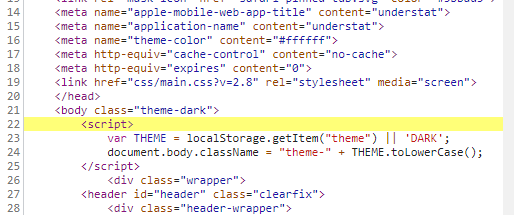

The second script we are able to call is grouped stats script : 


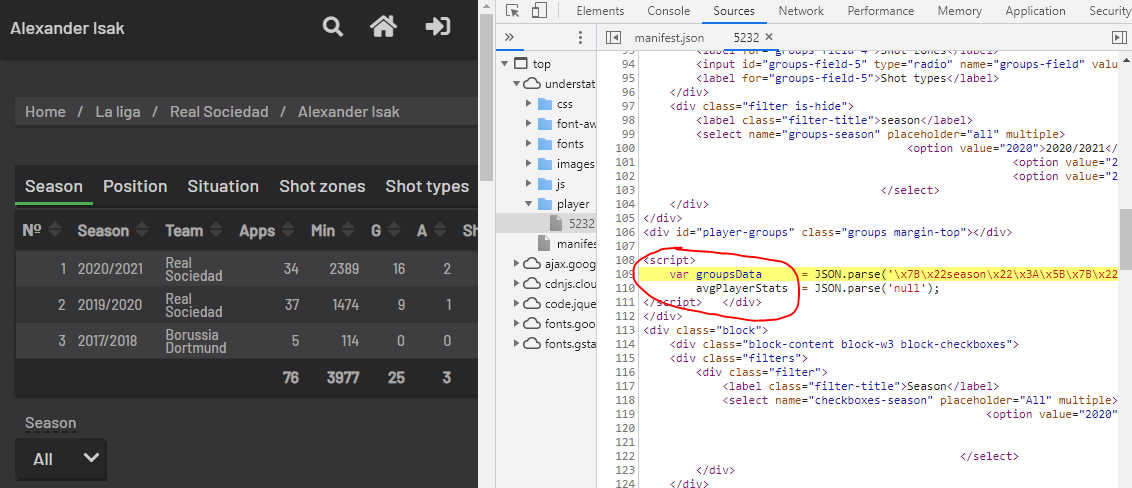

The third script we are able to call is the radar charts stats : 


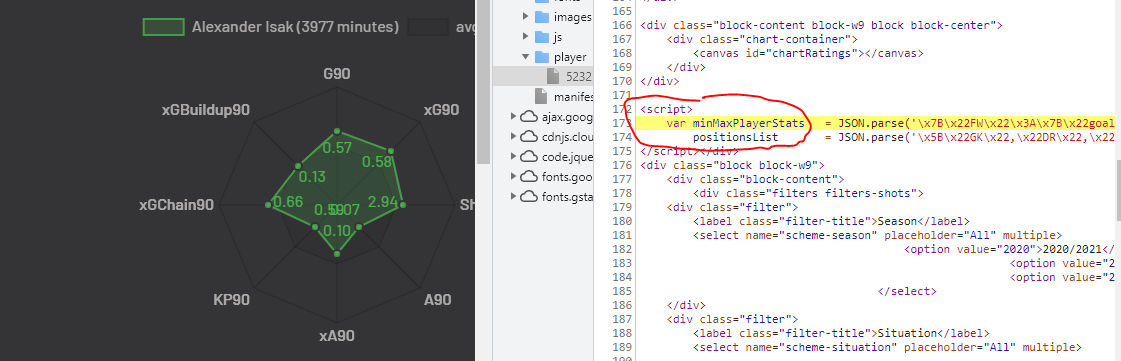

The fourth script we are able to call is the shots data : 



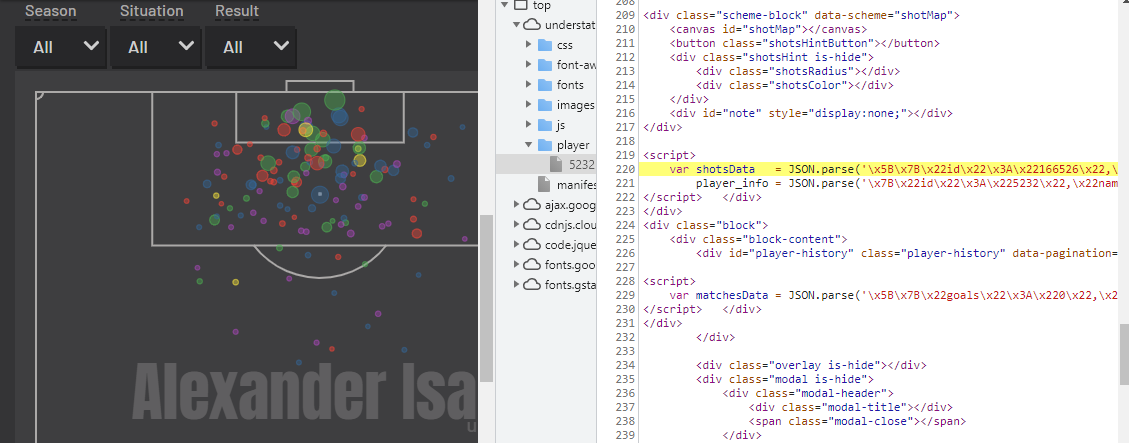



The last script we are able to call is the the stats per game by Isak : 
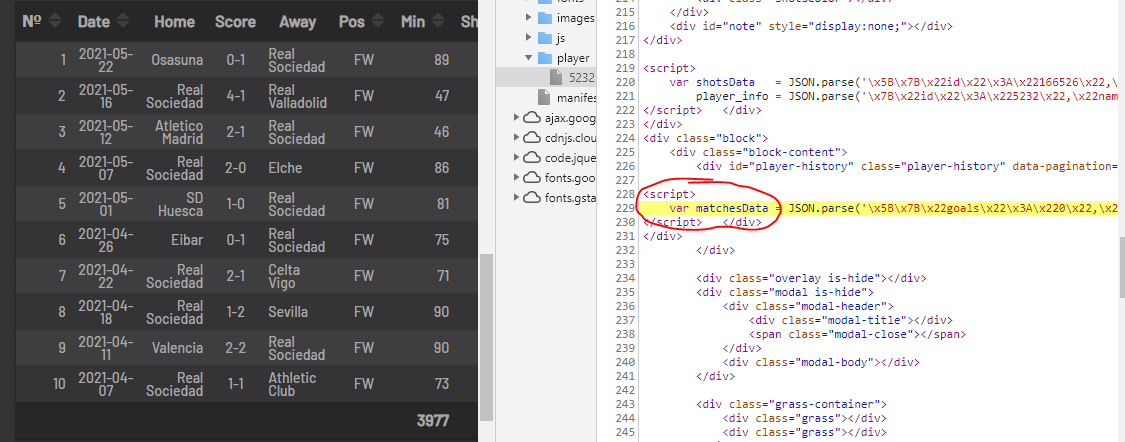

**It's very important to distinguish between the the number of scripts and their own number, remember in Python it starts at 0, for instance if we wish to call the shots script , it would be the fourth script but the number "[3]"**

<a id="3."></a>
# 3. Players data

Let's scrape all the data from the Understat page using Beautiful Soup and the player ID in this case for Isak 5232 

<a id="3.1"></a>
## 3.1. Players grouped stats

To get the json data from the Understat page we must first request, find it and execute the script we want , in this case number [1] , the grouped data.

In [39]:
# Entering Aleksander Isak ID link
link = "https://understat.com/player/5232"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')
# Get the grouped stats data, it's the second script executed in order
strings = scripts[1].string

Now that we have the data we have to clean and get rid of the unnecessary characters 

In [40]:
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)

As with the Understat module and the Selenium tutorial , we cannot create a dataframe for data beacuse it'll lead to ambiguous ordering , logical given that the data is divided such as this : 

**To create the dataframes we can call the keys such as this pd.DataFrame(data['season'])**

This is for **data['season']** , this is going to be for the grouped stats organized by season
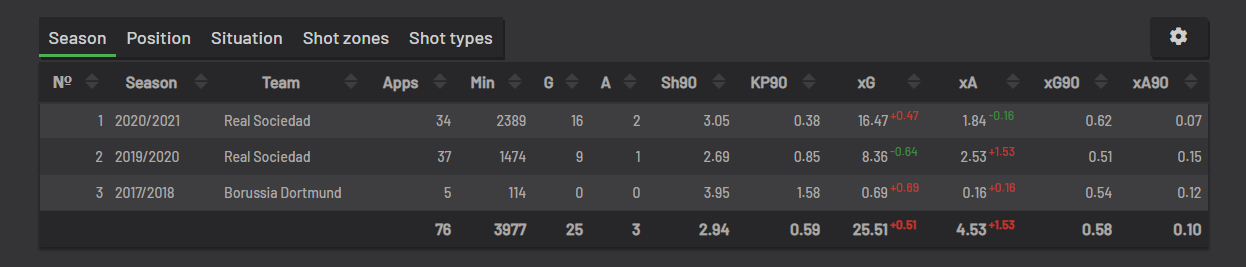




In [41]:
df = pd.DataFrame(data)

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

We must call several keys and create DataFrames of them

In [8]:
df = pd.DataFrame(data['season'])
df

,position,games,goals,shots,time,xG,assists,xA,key_passes,season,team,yellow,red,npg,npxG,xGChain,xGBuildup
0,FW,34,16,81,2389,16.467687502503395,2,1.841515245847404,10,2020,Real Sociedad,4,0,16,15.724409859627485,17.613966742530465,2.982304299250245
1,Sub,37,9,44,1474,8.358875419944525,1,2.5289357006549835,14,2019,Real Sociedad,4,0,9,8.358875419944525,9.927118256688118,2.0546590453013778
2,Sub,5,0,5,114,0.688359834253788,0,0.15696034580469131,2,2017,Borussia Dortmund,0,0,0,0.688359834253788,1.4718853048980236,0.6392971016466618


For some keys such as shotZones, shotTypes and OpenPlays , they are nested , meaning they have dictionaries inside dictionaries and if we proceed to create dataframes with them , we'll obtain dataframes with dictionaries inside them, this is a good example : 

In [47]:
df = pd.DataFrame(data['shotTypes'])
df

,2017,2019,2020
Head,"{'shotTypes': 'Head', 'season': '2017', 'goals...","{'shotTypes': 'Head', 'season': '2019', 'goals...","{'shotTypes': 'Head', 'season': '2020', 'goals..."
RightFoot,"{'shotTypes': 'RightFoot', 'season': '2017', '...","{'shotTypes': 'RightFoot', 'season': '2019', '...","{'shotTypes': 'RightFoot', 'season': '2020', '..."
LeftFoot,"{'shotTypes': 'LeftFoot', 'season': '2017', 'g...","{'shotTypes': 'LeftFoot', 'season': '2019', 'g...","{'shotTypes': 'LeftFoot', 'season': '2020', 'g..."


To unnest them what we can do is to apply the series function and create more dataframes out of it 

In [49]:
df['2017'].apply(pd.Series)

,shotTypes,season,goals,shots,xG,assists,key_passes,xA,npg,npxG
Head,Head,2017,0,2,0.09148484747856855,0,0,0,0,0.09148484747856855
RightFoot,RightFoot,2017,0,2,0.5112962201237679,0,2,0.15696034580469131,0,0.5112962201237679
LeftFoot,LeftFoot,2017,0,1,0.08557876944541931,0,0,0,0,0.08557876944541931


And just like that we obtain an unnested DataFrame, here's an alternative method , done by just calling 2 keys with the dictionary : 

In [51]:
pd.DataFrame(data['shotTypes']['2017']).T

,shotTypes,season,goals,shots,xG,assists,key_passes,xA,npg,npxG
Head,Head,2017,0,2,0.09148484747856855,0,0,0,0,0.09148484747856855
RightFoot,RightFoot,2017,0,2,0.5112962201237679,0,2,0.15696034580469131,0,0.5112962201237679
LeftFoot,LeftFoot,2017,0,1,0.08557876944541931,0,0,0,0,0.08557876944541931


And we obtain the exact same result. There are more keys to explore such as shotZones , shotTypes and situation 


<a id="3.2"></a>
## 3.2. Players shot data 

Same procedure as the grouped stats except the script for the player shots is the fourth instead of the third and remember python starts on 0 so it's the 4 script available to execute but when called it's [3] 

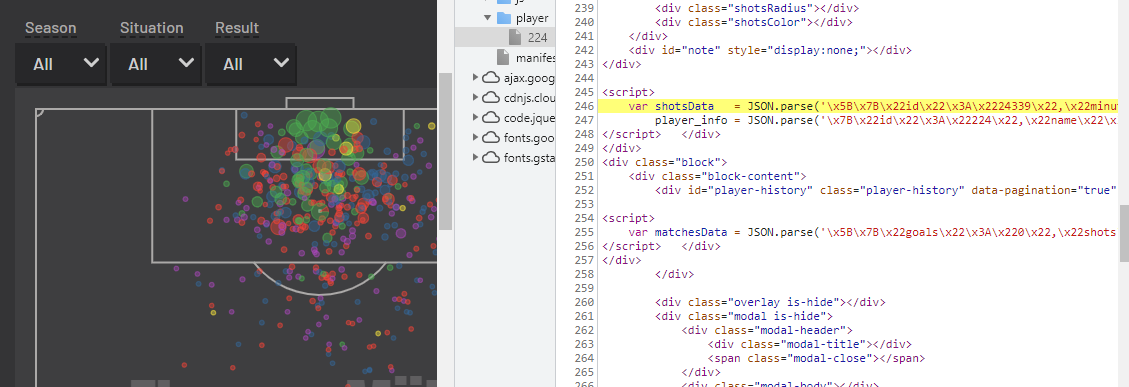

In [18]:
# Entering Aleksander Isak ID link
link = "https://understat.com/player/5232"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')
# Get the grouped stats data, it's the second script executed in order
strings = scripts[3].string
# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)

Contrary to grouped stats,the creation of DataFrames for  the shot data is pretty straightforward given that we do not have any nested data 

In [20]:
df = pd.DataFrame(data)
df

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,166526,88,MissedShots,0.9490000152587891,0.30100000381469727,0.06867415457963943,Alexander Isak,h,5232,OpenPlay,2017,RightFoot,8294,Borussia Dortmund,FC Cologne,5,0,2017-09-17 17:00:00,Sokratis,Pass
1,187991,19,MissedShots,0.935,0.54,0.07875283062458038,Alexander Isak,h,5232,OpenPlay,2017,Head,8412,Borussia Dortmund,Wolfsburg,0,0,2018-01-14 17:00:00,Andriy Yarmolenko,Aerial
2,187994,28,MissedShots,0.86,0.545,0.01273201685398817,Alexander Isak,h,5232,FromCorner,2017,Head,8412,Borussia Dortmund,Wolfsburg,0,0,2018-01-14 17:00:00,Shinji Kagawa,Aerial
3,188000,41,ShotOnPost,0.9230000305175782,0.43,0.4426220655441284,Alexander Isak,h,5232,OpenPlay,2017,RightFoot,8412,Borussia Dortmund,Wolfsburg,0,0,2018-01-14 17:00:00,Mario Götze,Throughball
4,188419,85,BlockedShot,0.8719999694824219,0.4329999923706055,0.08557876944541931,Alexander Isak,a,5232,OpenPlay,2017,LeftFoot,8423,Hertha Berlin,Borussia Dortmund,1,1,2018-01-19 19:30:00,Shinji Kagawa,Chipped
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,422681,15,Goal,0.875,0.3160000038146973,0.055002592504024506,Alexander Isak,h,5232,OpenPlay,2020,RightFoot,15145,Real Sociedad,Real Valladolid,4,1,2021-05-16 16:30:00,Mikel Oyarzabal,Pass
126,422684,32,SavedShot,0.9030000305175782,0.27,0.09489905089139938,Alexander Isak,h,5232,OpenPlay,2020,RightFoot,15145,Real Sociedad,Real Valladolid,4,1,2021-05-16 16:30:00,David Silva,Pass
127,423770,52,BlockedShot,0.7919999694824219,0.5540000152587891,0.03807836398482323,Alexander Isak,a,5232,OpenPlay,2020,LeftFoot,15153,Osasuna,Real Sociedad,0,1,2021-05-22 16:00:00,David Silva,Pass
128,423774,65,MissedShots,0.935,0.645,0.28829410672187805,Alexander Isak,a,5232,OpenPlay,2020,LeftFoot,15153,Osasuna,Real Sociedad,0,1,2021-05-22 16:00:00,David Silva,Pass


And now we have the entire shot data for Aleksander Isak career

<a id="3.3"></a>
## 3.3. Match data


Same procedure as before but using instead the last script , belonging to the stats by Isak

In [33]:
# Entering Aleksander Isak ID link
link = "https://understat.com/player/5232"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')
# Get the grouped stats data, it's the second script executed in order
strings = scripts[4].string # number 4 script and fifth executable 
# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)

Once again pretty straightforward to execute

In [34]:
df = pd.DataFrame(data)
df

,goals,shots,xG,time,position,h_team,a_team,h_goals,a_goals,date,id,season,roster_id,xA,assists,key_passes,npg,npxG,xGChain,xGBuildup
0,0,3,0.8916047215461731,89,FW,Osasuna,Real Sociedad,0,1,2021-05-22,15153,2020,473030,0,0,0,0,0.8916047215461731,0.6344904899597168,0.30811798572540283
1,2,3,0.20789402723312378,47,FW,Real Sociedad,Real Valladolid,4,1,2021-05-16,15145,2020,471788,0,0,0,2,0.20789402723312378,0.23746855556964874,0.029574526473879814
2,0,2,0.23965221643447876,46,FW,Atletico Madrid,Real Sociedad,2,1,2021-05-12,15128,2020,470459,0,0,0,0,0.23965221643447876,0.3388743996620178,0.25052669644355774
3,0,3,0.7542624473571777,86,FW,Real Sociedad,Elche,2,0,2021-05-07,15125,2020,468244,0,0,0,0,0.7542624473571777,0.7738361954689026,0.019573763012886047
4,0,3,0.11855480074882507,81,FW,SD Huesca,Real Sociedad,1,0,2021-05-01,15116,2020,467147,0,0,0,0,0.11855480074882507,0.10712171345949173,0.07719390839338303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,0,0,12,Sub,Borussia Dortmund,Freiburg,2,2,2018-01-27,8430,2017,210452,0,0,0,0,0,0.023716244846582413,0.023716244846582413
72,0,1,0.08557876944541931,23,Sub,Hertha Berlin,Borussia Dortmund,1,1,2018-01-19,8423,2017,208780,0.08541300147771835,0,1,0,0.08557876944541931,0.17099177837371826,0
73,0,3,0.5341069102287292,68,FW,Borussia Dortmund,Wolfsburg,0,0,2018-01-14,8412,2017,208323,0.07154734432697296,0,1,0,0.5341069102287292,1.2085031270980835,0.6155808568000793
74,0,0,0,8,Sub,Borussia Dortmund,Werder Bremen,1,2,2017-12-09,8385,2017,199550,0,0,0,0,0,0,0


<a id="3.4"></a>
## 3.4. Radar data

In case you want to plot any radar to compare players , this data will be useful, this time using the third script available to execute

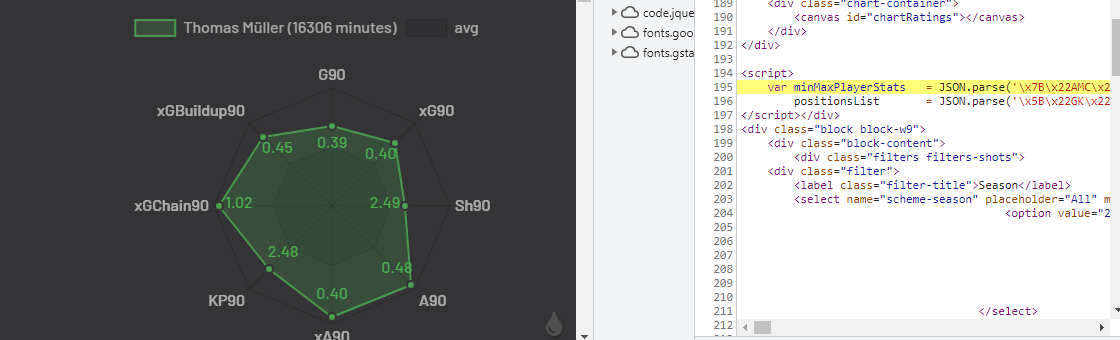



In [35]:
# Entering Aleksander Isak ID link
link = "https://understat.com/player/5232"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')
# Get the grouped stats data, it's the second script executed in order
strings = scripts[2].string # number 4 script and fifth executable 
# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)

As it happens in some cases the data is nested

In [38]:
df = pd.DataFrame(data['FW']).T
df

,min,max,avg
goals,0.001100,0.012600,0.004200
xG,0.001728,0.012082,0.004155
shots,0.015000,0.073700,0.028000
assists,0.000000,0.004800,0.001400
xA,0.000264,0.005382,0.001316
key_passes,0.003600,0.030900,0.012000
xGChain,0.002727,0.016914,0.005338
xGBuildup,0.000243,0.006713,0.001318


<a id="4."></a>
# 4. Match data

Let's focus now on the data we can scrape by using the Beautiful Soup library and the match's IDs.

<a id="4.1"></a>
## 4.1. Shot Data

For the matches data links, the order and the number of scripts change : 

The second script available ,[1] to call it is the shotsData : 
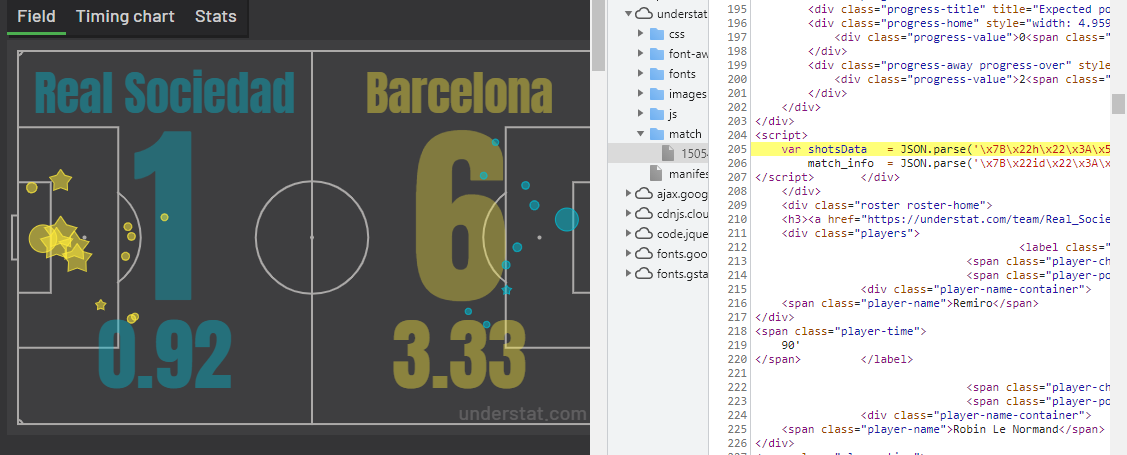 


In [2]:
# Entering Real Sociedad vs Barcelona match link
link = "https://understat.com/match/15054"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')
# Get the shotsData, it's the second script executed in order
strings = scripts[1].string 
# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)

As it's happened before the shots data for the Barcelona vs Sociedad match is nested into home and away "h","a". To unnest them we must create to different DataFrames and merge them together : 

In [67]:
df_h = pd.DataFrame(data['h'])
df_a = pd.DataFrame(data['a'])
df = df_h.append(df_a)
df

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,412061,5,BlockedShot,0.765,0.3029999923706055,0.013110247440636158,Mikel Oyarzabal,h,2234,OpenPlay,2020,LeftFoot,15054,Real Sociedad,Barcelona,1,6,2021-03-21 20:00:00,Alexander Isak,HeadPass
1,412064,23,SavedShot,0.9319999694824219,0.5479999923706055,0.5092174410820007,Alexander Isak,h,5232,OpenPlay,2020,RightFoot,15054,Real Sociedad,Barcelona,1,6,2021-03-21 20:00:00,None,BallRecovery
2,412068,38,SavedShot,0.8619999694824219,0.639000015258789,0.05224307253956795,Alexander Isak,h,5232,OpenPlay,2020,RightFoot,15054,Real Sociedad,Barcelona,1,6,2021-03-21 20:00:00,Mikel Merino,Pass
3,412071,48,BlockedShot,0.8109999847412109,0.754000015258789,0.016946742311120033,Martín Merquelanz,h,7101,OpenPlay,2020,LeftFoot,15054,Real Sociedad,Barcelona,1,6,2021-03-21 20:00:00,Mikel Oyarzabal,Pass
4,412077,72,SavedShot,0.7959999847412109,0.26799999237060546,0.01787463203072548,Adnan Januzaj,h,323,OpenPlay,2020,LeftFoot,15054,Real Sociedad,Barcelona,1,6,2021-03-21 20:00:00,Carlos Fernández,Pass
5,412078,76,Goal,0.83,0.36,0.04758581146597862,Ander Barrenetxea,h,7308,OpenPlay,2020,RightFoot,15054,Real Sociedad,Barcelona,1,6,2021-03-21 20:00:00,Carlos Fernández,Pass
6,412080,84,MissedShots,0.8290000152587891,0.42700000762939455,0.06065621227025986,Jon Bautista,h,2238,OpenPlay,2020,RightFoot,15054,Real Sociedad,Barcelona,1,6,2021-03-21 20:00:00,Ander Barrenetxea,Pass
7,412081,86,SavedShot,0.8480000305175781,0.47400001525878904,0.08227799832820892,Carlos Fernández,h,2070,OpenPlay,2020,LeftFoot,15054,Real Sociedad,Barcelona,1,6,2021-03-21 20:00:00,Jon Bautista,Pass
8,412082,86,BlockedShot,0.7909999847412109,0.665,0.026389889419078827,Jon Bautista,h,2238,OpenPlay,2020,LeftFoot,15054,Real Sociedad,Barcelona,1,6,2021-03-21 20:00:00,Carlos Fernández,Pass
9,412084,92,BlockedShot,0.8769999694824219,0.585999984741211,0.09084589779376984,Adnan Januzaj,h,323,OpenPlay,2020,LeftFoot,15054,Real Sociedad,Barcelona,1,6,2021-03-21 20:00:00,Martín Merquelanz,Pass


Now we have the entire shot data for both Barcelona and Real Sociedad

<a id="4.2"></a>
## 4.2 Rosters data

Now let's scrap the rosters data for both teams , giving us the stats for the give match : 

The script number 3/ [2] is the one containing the rosters data : 

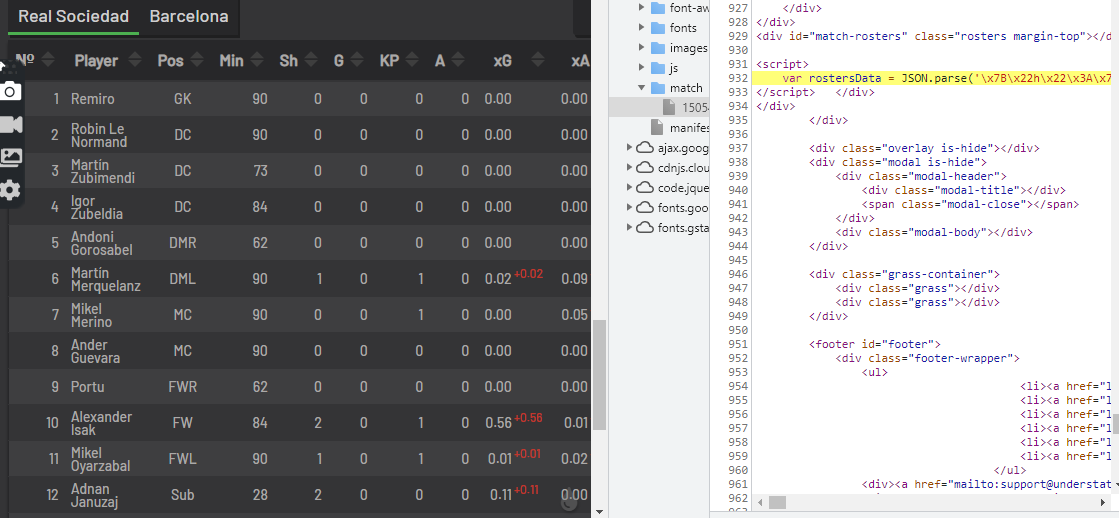

In [3]:
# Entering Real Sociedad vs Barcelona match link
link = "https://understat.com/match/15054"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')
# Get the Rosters data, it's the third script executed in order
strings = scripts[2].string 
# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)

In this case we focused on Barcelona's roster

In [7]:
df = pd.DataFrame(data['a']).T
df

,id,goals,own_goals,shots,xG,time,player_id,team_id,position,player,...,yellow_card,red_card,roster_in,roster_out,key_passes,assists,xA,xGChain,xGBuildup,positionOrder
458985,458985,0,0,0,0,90,2090,148,GK,Marc-André ter Stegen,...,0,0,0,0,0,0,0,0,0,1
458987,458987,0,0,0,0,90,7781,148,DC,Frenkie de Jong,...,0,0,0,0,0,0,0,1.63901948928833,1.63901948928833,3
458988,458988,0,0,0,0,90,9011,148,DC,Óscar Mingueza,...,0,0,0,0,0,0,0,0.9163206815719604,0.9163206815719604,3
458986,458986,0,0,1,0.03618575260043144,90,5050,148,DC,Clement Lenglet,...,0,0,0,0,0,0,0,0.6810662746429443,0.6448805332183838,3
458989,458989,2,0,2,0.9333615303039551,85,8979,148,DMR,Sergiño Dest,...,0,0,458997,0,1,0,0.13115915656089783,1.0645207166671753,0,5
458990,458990,0,0,1,0.031241005286574364,90,2093,148,DML,Jordi Alba,...,0,0,0,0,4,1,1.2747985124588013,1.6925973892211914,1.5769318342208862,6
458992,458992,0,0,1,0.05408518388867378,69,8935,148,MC,Pedri,...,0,0,459000,0,0,0,0,0.6989656686782837,0.6448805332183838,9
458991,458991,0,0,0,0,68,2095,148,MC,Sergio Busquets,...,1,0,458999,0,2,1,0.577187716960907,1.736548662185669,1.2142935991287231,9
458993,458993,2,0,5,1.2266441583633423,90,2097,148,AMC,Lionel Messi,...,0,0,0,0,2,1,0.37837645411491394,2.4371299743652344,1.4512264728546143,12
458994,458994,1,0,1,0.5789059996604919,86,2270,148,AMC,Antoine Griezmann,...,0,0,458998,0,1,0,0.03618575260043144,1.7934366464614868,1.1783448457717896,12


<a id="5."></a>
# 5. Get fixtures

In [21]:
# Entering the league's  link
link = "https://understat.com/league/La_liga"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')
# Get the fixtures data
strings = scripts[1].string 
# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)

In [18]:
df = pd.DataFrame(data)
df

,id,isResult,h,a,goals,xG,datetime,forecast
0,14136,True,"{'id': '156', 'title': 'Eibar', 'short_title':...","{'id': '152', 'title': 'Celta Vigo', 'short_ti...","{'h': '0', 'a': '0'}","{'h': '0.344008', 'a': '0.783653'}",2020-09-12 14:00:00,"{'w': '0.1401', 'd': '0.3904', 'l': '0.4695'}"
1,14137,True,"{'id': '155', 'title': 'Granada', 'short_title...","{'id': '147', 'title': 'Athletic Club', 'short...","{'h': '2', 'a': '0'}","{'h': '0.545144', 'a': '0.483337'}",2020-09-12 16:30:00,"{'w': '0.3131', 'd': '0.4505', 'l': '0.2364'}"
2,14138,True,"{'id': '261', 'title': 'Cadiz', 'short_title':...","{'id': '157', 'title': 'Osasuna', 'short_title...","{'h': '0', 'a': '2'}","{'h': '0.600934', 'a': '0.633286'}",2020-09-12 19:00:00,"{'w': '0.2773', 'd': '0.4141', 'l': '0.3086'}"
3,14139,True,"{'id': '158', 'title': 'Alaves', 'short_title'...","{'id': '153', 'title': 'Real Betis', 'short_ti...","{'h': '0', 'a': '1'}","{'h': '1.17642', 'a': '0.341233'}",2020-09-13 12:00:00,"{'w': '0.7103', 'd': '0.2358', 'l': '0.0539'}"
4,14140,True,"{'id': '231', 'title': 'Real Valladolid', 'sho...","{'id': '140', 'title': 'Real Sociedad', 'short...","{'h': '1', 'a': '1'}","{'h': '0.858211', 'a': '0.31178'}",2020-09-13 14:00:00,"{'w': '0.528', 'd': '0.3655', 'l': '0.1065'}"
...,...,...,...,...,...,...,...,...
375,15154,True,"{'id': '150', 'title': 'Real Madrid', 'short_t...","{'id': '154', 'title': 'Villarreal', 'short_ti...","{'h': '2', 'a': '1'}","{'h': '0.804298', 'a': '0.614418'}",2021-05-22 16:00:00,"{'w': '0.3671', 'd': '0.3806', 'l': '0.2523'}"
376,15156,True,"{'id': '231', 'title': 'Real Valladolid', 'sho...","{'id': '143', 'title': 'Atletico Madrid', 'sho...","{'h': '1', 'a': '2'}","{'h': '0.995635', 'a': '1.2916'}",2021-05-22 16:00:00,"{'w': '0.2801', 'd': '0.2957', 'l': '0.4242'}"
377,15157,True,"{'id': '207', 'title': 'Elche', 'short_title':...","{'id': '147', 'title': 'Athletic Club', 'short...","{'h': '2', 'a': '0'}","{'h': '1.33082', 'a': '0.303264'}",2021-05-22 16:00:00,"{'w': '0.7131', 'd': '0.2282', 'l': '0.0587'}"
378,15150,True,"{'id': '155', 'title': 'Granada', 'short_title...","{'id': '142', 'title': 'Getafe', 'short_title'...","{'h': '0', 'a': '0'}","{'h': '0.444987', 'a': '0.46059'}",2021-05-23 16:30:00,"{'w': '0.256', 'd': '0.4832', 'l': '0.2608'}"


As with other cases the fixtures are highly nested 

<a id="6."></a>
# 6. Get table

In [22]:
# Entering the league's  link
link = "https://understat.com/league/La_liga"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')
# Get the table 
strings = scripts[2].string 
# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)

In the case of the table it returns once again a nested dataframe, the column of interest is the history data, it contains data for every single match the team played. We'll focus on Barcelona, 148 ID and then on the key history. And now we have all 38 matches data for Barcelona's 2021 season

In [31]:
df = pd.DataFrame(data['148']['history'])
df

,h_a,xG,xGA,npxG,npxGA,ppda,ppda_allowed,deep,deep_allowed,scored,missed,xpts,result,date,wins,draws,loses,pts,npxGD
0,h,3.507350,0.244835,2.764080,0.244835,"{'att': 314, 'def': 21}","{'att': 383, 'def': 20}",17,6,4,0,2.9455,w,2020-09-27 19:00:00,1,0,0,3,2.519245
1,a,0.931689,0.568201,0.931689,0.568201,"{'att': 203, 'def': 18}","{'att': 283, 'def': 37}",7,5,3,0,1.7230,w,2020-10-01 19:30:00,1,0,0,3,0.363488
2,h,1.057170,1.255220,1.057170,1.255220,"{'att': 380, 'def': 24}","{'att': 370, 'def': 33}",3,2,1,1,1.1629,d,2020-10-04 19:00:00,0,1,0,1,-0.198050
3,a,0.625410,1.709920,0.625410,0.966769,"{'att': 76, 'def': 15}","{'att': 399, 'def': 35}",4,4,0,1,0.4856,l,2020-10-17 19:00:00,0,0,1,0,-0.341359
4,h,1.573510,3.208480,1.573510,2.465200,"{'att': 329, 'def': 28}","{'att': 351, 'def': 26}",5,8,1,3,0.4300,l,2020-10-24 14:00:00,0,0,1,0,-0.891690
5,a,2.077470,1.113240,2.077470,1.113240,"{'att': 100, 'def': 17}","{'att': 382, 'def': 18}",24,0,1,1,2.0668,d,2020-10-31 20:00:00,0,1,0,1,0.964230
6,h,4.444870,0.869910,2.958310,0.869910,"{'att': 274, 'def': 25}","{'att': 296, 'def': 15}",19,4,5,2,2.9277,w,2020-11-07 15:15:00,1,0,0,3,2.088400
7,a,1.299640,0.812108,1.299640,0.812108,"{'att': 280, 'def': 15}","{'att': 306, 'def': 15}",7,8,0,1,1.7721,l,2020-11-21 20:00:00,0,0,1,0,0.487532
8,h,3.914160,1.561180,3.914160,1.561180,"{'att': 168, 'def': 13}","{'att': 483, 'def': 23}",17,3,4,0,2.7127,w,2020-11-29 13:00:00,1,0,0,3,2.352980
9,a,1.710260,2.611180,1.710260,2.611180,"{'att': 64, 'def': 18}","{'att': 293, 'def': 11}",27,1,1,2,0.7133,l,2020-12-05 20:00:00,0,0,1,0,-0.900920


<a id="7."></a>
# 7. Getting all players stats

In [34]:
# Entering the league's  link
link = "https://understat.com/league/La_liga"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')
# Get the players stats 
strings = scripts[3].string 
# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)
# Creating the dataframe
df = pd.DataFrame(data)
df

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
0,2097,Lionel Messi,35,3017,30,26.676843278110027,9,11.422847747802734,195,77,4,0,F M S,Barcelona,27,22.96045546978712,37.906863175332546,20.33736250922084
1,2120,Gerard Moreno,33,2680,23,19.52812883257866,7,7.810236442834139,98,43,3,0,F M S,Villarreal,13,12.095480419695377,23.26353019475937,6.951297817751765
2,2370,Karim Benzema,34,2914,23,19.454521590843797,9,6.755567729473114,123,38,2,0,F S,Real Madrid,22,18.711243921890855,28.303930163383484,6.194142518565059
3,2098,Luis Suárez,32,2541,21,17.89246611110866,3,3.1426702942699194,104,27,6,0,F S,Atletico Madrid,18,15.662633268162608,18.595971453934908,1.2328046094626188
4,5169,Youssef En-Nesyri,38,2308,18,15.79480616375804,0,2.6420645620673895,77,13,2,0,F S,Sevilla,18,15.79480616375804,17.81611675210297,1.087053531780839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,9457,José Boacho,4,21,0,0.018616581335663795,0,0,1,0,1,0,S,Getafe,0,0.018616581335663795,0.03350281435996294,0.014886233024299145
566,9496,Alejandro Cantero,4,245,0,0.4423438832163811,0,1.082566563040018,3,3,1,0,F S,Levante,0,0.4423438832163811,1.4155199863016605,0.3262682557106018
567,9519,Carlos Domínguez,4,360,0,0.06754987686872482,0,0.03489396348595619,1,1,2,0,D,Celta Vigo,0,0.06754987686872482,0.2482907883822918,0.2482907883822918
568,9520,Hugo Sotelo,1,1,0,0,0,0,0,0,0,0,S,Celta Vigo,0,0,0,0
